Detect Corner 

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Corner Detection

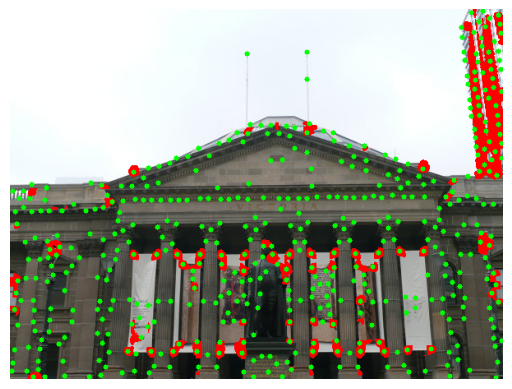

In [43]:
# Path to the image file
image_path = "../Data/Train/Set1/1.jpg"  # Ensure the correct image file name and type

# Read the image from the specified path
img = cv2.imread(image_path)
# Check if the image was successfully read
if img is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply the Harris corner detection
# img: input image
# blocksize: size of the neighborhood considered for corner detection
# ksize: aperture parameter of the Sobel derivative used
# k: Harris detector free parameter
harris_corners = cv2.cornerHarris(gray, 10, 15, 0.04)

# Apply the Shi-Tomasi corner detection
# gray: input image in grayscale
# maxCorners: maximum number of corners to return
# qualityLevel: minimum accepted quality of image corners
# minDistance: minimum possible Euclidean distance between the returned corners
shi_tomasi_corners = cv2.goodFeaturesToTrack(
    gray, maxCorners=500, qualityLevel=0.01, minDistance=10
)
# Convert the corner coordinates to integer values
shi_tomasi_corners = np.intp(shi_tomasi_corners)

# Draw strong Harris corners in the image
strong_corners = harris_corners > 0.01 * harris_corners.max()
img[strong_corners] = [0, 0, 255]

# Draw Shi-Tomasi corners on the image
for corner in shi_tomasi_corners:
    x, y = corner.ravel()
    cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

# Display the image with highlighted strong corners using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## Adaptive Non-Maximal Suppression (ANMS)

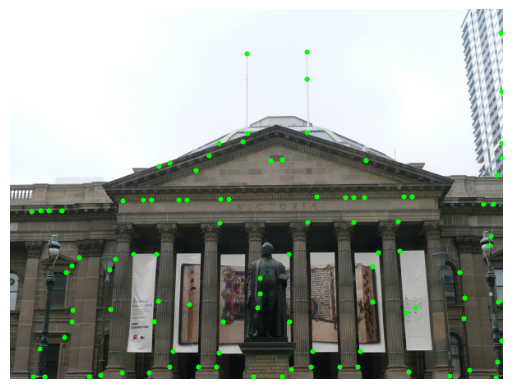

In [44]:
def anms(corners: np.ndarray, num_corners: int) -> np.ndarray:
    """
    Apply Adaptive Non-Maximal Suppression (ANMS) to the detected corners.

    Parameters:
    corners (np.ndarray): Array of detected corners.
    num_corners (int): Number of corners to retain after ANMS.

    Returns:
    np.ndarray: Array of corners retained after ANMS.
    """
    # Initialize radii with infinity
    radii = np.full(corners.shape[0], np.inf)

    # Calculate suppression radius for each corner
    for i, corner in enumerate(corners):
        for j, other_corner in enumerate(corners):
            if i != j:  # Skip the same corner
                # Check if the other corner is stronger than the current corner
                if np.all(corner < other_corner):
                    # Calculate the Euclidean distance between corners
                    dist = np.linalg.norm(corner - other_corner)
                    # Update the suppression radius with the minimum distance
                    radii[i] = min(radii[i], dist)

    # Select the top num_corners corners based on the suppression radius
    top_indices = np.argsort(radii)[-num_corners:]
    top_corners = corners[top_indices]

    return top_corners


# Apply ANMS to the detected corners
num_corners = 100  # Number of corners to retain after ANMS

anms_corners = anms(shi_tomasi_corners.reshape(-1, 2), num_corners)

# Draw ANMS corners on the image
img = cv2.imread(image_path)
for corner in anms_corners:
    x, y = corner.ravel()
    cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

# Display the image with ANMS corners using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## Feature Descriptor

In [45]:
def get_feature_descriptor(
    img: np.ndarray, points: np.ndarray, size: int = 40
) -> np.ndarray:
    """
    Extracts and processes feature descriptors from the given image at the specified points.

    Parameters:
    img (np.ndarray): The input image.
    points (np.ndarray): The points at which the feature descriptors are to be extracted.
    size (int): The size of the patch to be extracted. Default is 40.

    Returns:
    np.ndarray: The processed feature descriptors.
    """

    def get_patch(img: np.ndarray, point: tuple[int, int], size: int) -> np.ndarray:
        """
        Extracts a square patch from the given image centered at the specified point.

        Parameters:
        img (np.ndarray): The input image from which the patch is to be extracted.
        point (tuple[int, int]): A tuple (x, y) representing the center of the patch in the image.
        size (int): The size of the patch to be extracted. The patch will be of dimensions size x size.

        Returns:
        np.ndarray: The extracted image patch of dimensions size x size.

        Notes:
        - The input image is padded with zeros to handle boundary conditions.
        - If the specified point is near the edge of the image, the patch will include the padded zeros.
        - OpenCV's coordinate system is flipped, so ensure the point coordinates are provided accordingly.
        """
        # Pad the image with zeros to handle boundary conditions
        img = np.pad(
            img,
            ((size//2, size//2), (size//2, size//2)),
            mode="constant",
            constant_values=0,
        )
        # Calculate the starting coordinates of the patch
        x_start, y_start = point[1], point[0] # Flip the coordinates for OpenCV
        # Extract the patch from the padded image
        img_patch = img[x_start : x_start + size, y_start : y_start + size]

        return img_patch

    def process_feature(image_patch: np.ndarray, subsample_size: int = 5) -> np.ndarray:
        """
        Processes the image patch to create a feature descriptor.

        Parameters:
        image_patch (np.ndarray): The input image patch.
        subsample_size (int): The size of the step to be used for subsampling. Default is 8.

        Returns:
        np.ndarray: The processed feature descriptor.
        """
        # Apply Gaussian Blur to the image patch
        blurred_patch = cv2.GaussianBlur(image_patch, (5, 5), cv2.BORDER_DEFAULT) 
        # Subsample the blurred image patch to create the descriptor
        descriptor = blurred_patch[::subsample_size, ::subsample_size]
        # Normalize the descriptor to have zero mean and unit variance
        descriptor = (descriptor - np.mean(descriptor)) / np.std(descriptor)
        # Reshape the descriptor to a column vector
        descriptor = descriptor.reshape((-1, 1))
        return descriptor

    def standardize_vector(vector: np.ndarray) -> np.ndarray:
        """
        Standardizes the given vector.

        Parameters:
        vector (np.ndarray): The input vector to be standardized.

        Returns:
        np.ndarray: The standardized vector.
        """
        # Calculate the mean of the vector
        mean = np.mean(vector)
        # Calculate the standard deviation of the vector
        std_dev = np.std(vector)
        # Standardize the vector
        if std_dev == 0:
            standardized_vector = vector - mean
        else:
            standardized_vector = (vector - mean) / std_dev
        return standardized_vector

    descriptors = []
    for point in points:
        # Extract the patch from the image
        patch = get_patch(img, point, size)
        # Process the patch to create the feature descriptor
        vector = process_feature(patch)
        # Standardize the feature descriptor
        standardized_vector = standardize_vector(vector)
        descriptors.append(standardized_vector)

    return np.array(descriptors)


# Example usage
# Read the image from the specified path
img = cv2.imread(image_path)
# Check if the image was successfully read
if img is None:
    raise FileNotFoundError(f"Image not found at the specified path: {image_path}")
# Convert the image to grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Extract and process the feature descriptor with the specified ANMS corners
descriptor = get_feature_descriptor(img, anms_corners)
print(f"Feature Descriptor Shape: {descriptor.shape}")


Feature Descriptor Shape: (100, 64, 1)
